### Resumo

In [1]:
#Importação das bibliotecas necessárias

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.core.dtypes.api import is_numeric_dtype

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score, accuracy_score, silhouette_samples

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
#Carga dos dados
data = pd.read_csv('CAR-clusterização.csv')
print(data.head())

    Nome do Município   APP  Altitude Superior 1800  Consolidada  \
0           Belo Vale  4489                       0          844   
1               Betim  2664                       0          446   
2              Bonfim  6133                       0         1749   
3          Brumadinho  7419                       0          787   
4  Cachoeira da Prata   330                       0           67   

   Declividade Maior 45  Imoveis  Pousio  Topo de Morro  Banhado  \
0                     3     1055      47              2        3   
1                     2      741       9              1        3   
2                     1     2064      41              1        0   
3                    15     1177      44              8        1   
4                     0       61       1              0        1   

   Borda Chapada  Hidrografia  Manguezal  Nascentes  Reserva Legal  Restinga  \
0              0          948          0        412            859         0   
1              0      

In [3]:
#Visualização do tipo dos dados

data.dtypes

Nome do Município          object
APP                         int64
Altitude Superior 1800      int64
Consolidada                 int64
Declividade Maior 45        int64
Imoveis                     int64
Pousio                      int64
Topo de Morro               int64
Banhado                     int64
Borda Chapada               int64
Hidrografia                 int64
Manguezal                   int64
Nascentes                   int64
Reserva Legal               int64
Restinga                    int64
Servidão Administrativa     int64
Restrito                    int64
Vegetação Nativa            int64
Vereda                      int64
dtype: object

In [4]:
#Remoção dos dados categóricos

df = data.select_dtypes(include=np.number)

In [5]:
#Visualização dos valores extremos

print(df.max())
print(df.min())

APP                        15142
Altitude Superior 1800         1
Consolidada                 2235
Declividade Maior 45          17
Imoveis                     2064
Pousio                       150
Topo de Morro                 27
Banhado                       60
Borda Chapada                  5
Hidrografia                 2069
Manguezal                      1
Nascentes                   1544
Reserva Legal               2540
Restinga                      58
Servidão Administrativa      628
Restrito                     333
Vegetação Nativa            2837
Vereda                     34489
dtype: int64
APP                        262
Altitude Superior 1800       0
Consolidada                 49
Declividade Maior 45         0
Imoveis                     61
Pousio                       0
Topo de Morro                0
Banhado                      0
Borda Chapada                0
Hidrografia                 34
Manguezal                    0
Nascentes                    5
Reserva Legal        

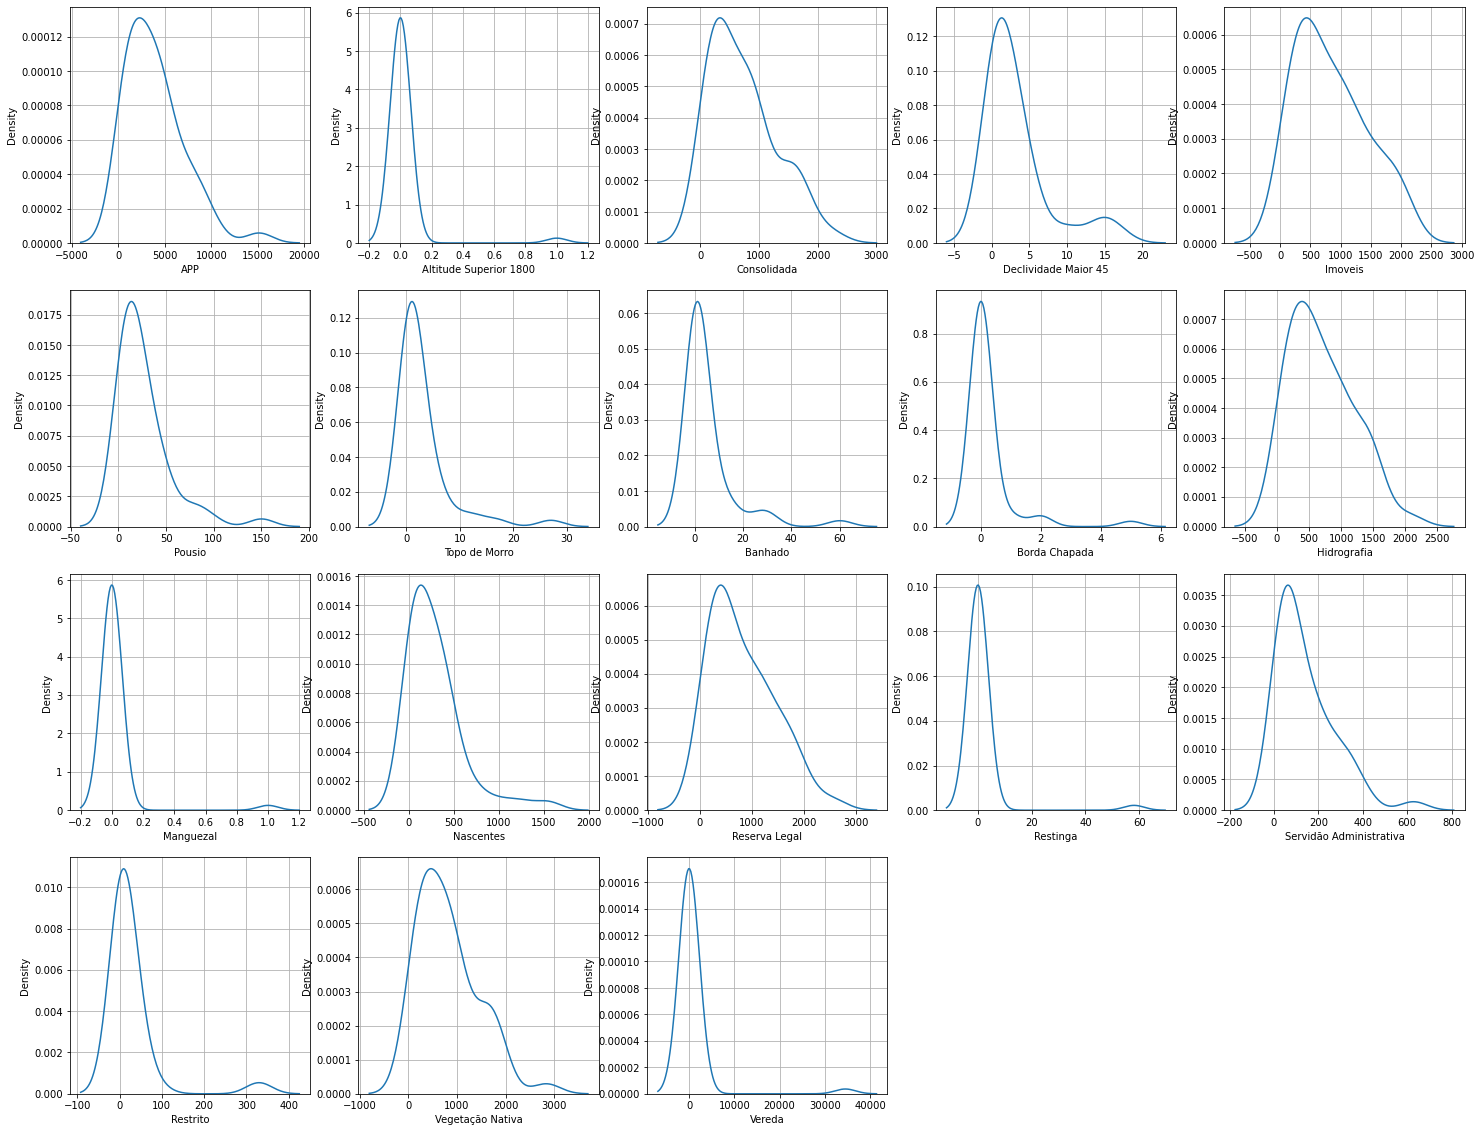

In [6]:
def distribuicoes(df, ncolunas):
  natributos = len(df.columns)
  nlinhas = natributos // ncolunas + (natributos % ncolunas != 0)
  fig, axes = plt.subplots(nlinhas, ncolunas, figsize=(5*ncolunas, 5*nlinhas))
  for x,atributo in enumerate(df.columns):
    i = x // ncolunas
    j = x % ncolunas
    sns.kdeplot(data=df, x=atributo, ax=axes[i,j])
    axes[i,j].grid()

  for x in range(j+1, ncolunas):
    fig.delaxes(axes[i,x])
  plt.show()

distribuicoes(df,5)

In [7]:
#Normalização dos valores
#Normalização min-max

df_norm = minmax_scale(df)

#d = pd.DataFrame(df_norm)
#distribuicoes(d,5)


In [8]:
#Método Elbow (ou Método do "Joelho"): Encontrando um valor ideal para o número de clusters
inicio = 2
fim = 20
inercia = []

for i in range(inicio, fim):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df_norm)
    inercia.append(kmeans.inertia_)

#Cálculo da maior queda do "joelho"
diferencas = []
for j in range(2,len(inercia)):
    if j+1 != len(inercia):
        t = []
        m = inercia[j] - inercia[j+1]
        t.append(j+1)
        t.append(m)
        diferencas.append(t)

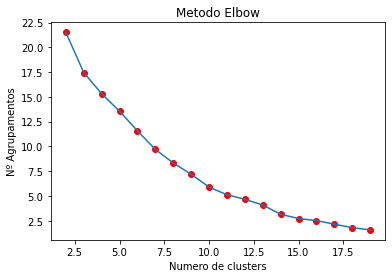

In [10]:
#Gráfico da variância em relação ao número de clusters
#Lembrando: maior a variância, maior a dispersão dos dados
plt.plot(range(inicio, fim), inercia)
plt.scatter(range(inicio, fim), inercia, c='red')
plt.title('Metodo Elbow')
plt.xlabel('Numero de clusters')
plt.ylabel('Nº Agrupamentos')
plt.show()

In [11]:
#O valor de K escolhido será aquele que possui a maior diferença associado, representando assim a maior queda
print(diferencas)

[[3, 1.7771068351473573], [4, 1.97391794227857], [5, 1.8810983458878319], [6, 1.3665009521420206], [7, 1.144302805572253], [8, 1.293982981792297], [9, 0.7737548897813502], [10, 0.4569010782088707], [11, 0.5856452647179857], [12, 0.9255173501541374], [13, 0.4361180145190504], [14, 0.203916812226125], [15, 0.3680772501171945], [16, 0.34295433435014355], [17, 0.232178103356524]]


In [12]:
#Ordena o vetor de forma decrescente com base na diferença calculada
valorK = sorted(diferencas, key=lambda diferenca: diferenca[1], reverse=True)
#maior valor da diferenca
print(valorK[0])

[4, 1.97391794227857]


In [13]:
#Silhouete Score

In [14]:
#PCA = Reduzindo a dimensionalidade dos dados
#OBS.: Reduzindo a dimensão, é perdido a informação dos valores dos dados

pca = PCA(n_components = 2)
pcaTransformacao = pca.fit_transform(df_norm)

In [34]:
#Algoritmo K-Means

#Calculando os agrupamentos dos dados na dimensão K
K = valorK[0][0]
kmeans = KMeans(n_clusters = K, random_state = 0, max_iter = 100)
cluster = kmeans.fit_predict(pcaTransformacao)
#cluster = kmeans.fit_predict(df_norm)

#Centroides de cada um dos clusters gerados
centroids = kmeans.cluster_centers_

#print(cluster)
print(centroids)

[[ 0.20897147  0.58211607]
 [ 0.16595461 -0.1151    ]
 [ 1.05650937 -0.1631417 ]
 [-0.5721779  -0.03446914]]


In [28]:
#Algoritmo KMeans sem uso do PCA
#Importância: Pegar os valores dos dados dos centroides dos agrupomentos

df = df.select_dtypes(include=np.number)
min_max = MinMaxScaler()
df_norm_2 = min_max.fit_transform(df)

K = valorK[0][0]
kmeans = KMeans(n_clusters = K, random_state = 0, max_iter = 100)
cluster = kmeans.fit_predict(df_norm_2)
centroide_dado_bruto = kmeans.cluster_centers_

valor_referencia_centroide = min_max.inverse_transform(centroide_dado_bruto)

print(valor_referencia_centroide)

[[ 5.10200000e+03  1.66666667e-01  7.90166667e+02  1.18333333e+01
   9.03333333e+02  2.81666667e+01  9.83333333e+00  1.08333333e+01
   1.50000000e+00  7.74500000e+02  3.46944695e-18  4.69666667e+02
   8.87500000e+02  5.00000000e-01  1.26166667e+02  2.20000000e+01
   8.51833333e+02  1.53333333e+01]
 [ 1.57900000e+03  6.93889390e-18  2.75695652e+02  1.34782609e+00
   3.58608696e+02  9.56521739e+00  1.08695652e+00  1.91304348e+00
  -1.38777878e-16  2.88260870e+02  6.93889390e-18  1.05478261e+02
   3.26652174e+02  8.69565217e-02  5.04347826e+01  4.30434783e+00
   3.30217391e+02  3.34782609e+00]
 [ 4.45300000e+03 -3.46944695e-18  8.75700000e+02  1.80000000e+00
   1.08230000e+03  4.07000000e+01  1.40000000e+00  7.60000000e+00
   1.00000000e-01  8.86300000e+02 -3.46944695e-18  3.41600000e+02
   1.02600000e+03  0.00000000e+00  1.87100000e+02  4.41000000e+01
   9.84800000e+02  3.45880000e+03]
 [ 8.43300000e+03  0.00000000e+00  1.67388889e+03  4.00000000e+00
   1.77755556e+03  5.03333333e+01  4.

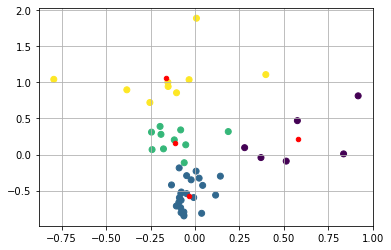

In [29]:
#Plotagem bidimensional dos agrupamentos formados

plt.scatter(pcaTransformacao[:,1], pcaTransformacao[:,0], c=cluster)
plt.grid()
plt.scatter(centroids[:,1], centroids[:,0], s=20, c='red')
plt.show()

In [61]:
#Visualização das cidades em cada um dos agrupamentos formados

#REFATORAR ESSE CÓDIGO AQUI

c0 = []
c1 = []
c2 = []
c3 = []
c4 = []
c5 = []
c6 = []
indice = 0
cidades = []

for i in cluster:
    
    if i == 0:
        c0.append(data['Nome do Município'][indice])
    elif i == 1:
        c1.append(data['Nome do Município'][indice])
    elif i == 2:
        c2.append(data['Nome do Município'][indice])
    elif i == 3:
        c3.append(data['Nome do Município'][indice])
    elif i == 4:
        c4.append(data['Nome do Município'][indice])
    elif i == 5:
        c5.append(data['Nome do Município'][indice])
    else:
        c6.append(data['Nome do Município'][indice])
    indice+=1

if len(c0) != 0:
    cidades.append(c0)
if len(c1) != 0:
    cidades.append(c1)
if len(c2) != 0:
    cidades.append(c2)
if len(c3) != 0:
    cidades.append(c3)
if len(c4) != 0:
    cidades.append(c4)
if len(c5) != 0:
    cidades.append(c5)
if len(c6) != 0:
    cidades.append(c6)

display(cidades)

[['Brumadinho',
  'Casa Grande',
  'Felixlândia',
  'Mateus Lemes',
  'Ouro Preto',
  'Queluzito'],
 ['Belo Vale',
  'Conselheiro Lafaiete',
  'Crucilândia',
  'Itatiaiuçu',
  'Itaverava',
  'Jeceaba',
  'Moeda',
  'Piedade dos Gerais',
  'Pompéu',
  'Rio Manso',
  'Sete Lagoas'],
 ['Bonfim',
  'Curvelo',
  'Desterro de Entre Rios',
  'Entre Rios de Minas',
  'Esmeraldas',
  'Itaúna',
  'Lagoa Dourada',
  'Pará de Minas',
  'Resende Costa'],
 ['Betim',
  'Cachoeira da Prata',
  'Caetanópolis',
  'Congonhas',
  'Contagem',
  'Cristiano Otoni',
  'Florestal',
  'Fortuna de Minas',
  'Ibirité',
  'Igarapé',
  'Inhaúma',
  'Juatuba',
  'Maravilhas',
  'Mario Campos',
  'Ouro Branco',
  'Papagaios',
  'Paraopeba',
  'Pequi',
  'São Brás do Suaçuí',
  'São Joaquim de Bicas',
  'São José da Varginha',
  'Sarzedo']]

In [107]:
#Separar os valores de PCA por agrupamento
pos = 0
valores_PCA_cluster = []
t = []

for cidade in c0:
    valores_PCA = []
    for i in data['Nome do Município']:
        if cidade == i:
            valores_PCA.append(pcaTransformacao[pos])
        pos = pos + 1
    pos = 0
    valores_PCA_cluster.append(valores_PCA)

display(valores_PCA_cluster)

[[array([0.47003817, 0.57581819])],
 [array([0.00868691, 0.83588233])],
 [array([0.09498896, 0.27908746])],
 [array([-0.04269139,  0.37097483])],
 [array([0.81450839, 0.91785342])],
 [array([-0.09170222,  0.51308021])]]

In [126]:
#Para cada agrupamento, determinar o ponto mais próximo do centroide

#Para cada um dos centroides gerados, identificar o ponto (cidade) mais próximo, calculando a distância euclidiana 
#entre o centróide de cada agrupamento e todos os pontos associados

import math

agrupamento = []
coordDist = []
pontoMaisProx = []

for i in range(0,K):
    agrupamento.append(i)

for valor in valores_PCA_cluster: 
    val = []
    x = valor[0][0]-centroids[0][0]
    y = valor[0][1]-centroids[0][1]
    delta = abs(pow(x,2) - pow(y,2))
    val.append(math.sqrt(delta))
    coordDist.append(val)
    
'''
for valor in agrupamento:
    #Calcula a distância de cada centroide para todos os pontos do agrupamento
    for i in valores_PCA_cluster:
        val = []
        val.append(i)
        x = i[valor][0]-centroids[valor][0]
        y = i[valor][1]-centroids[valor][1]
        
        
        delta = abs(pow(x,2) - pow(y,2))
        #Adiciona a distância euclidiana calculada
        val.append(math.sqrt(delta))
        coordDist.append(val)

    #Ordena o vetor de forma crescente com base na distância euclidiana calculada
    prox = sorted(coordDist, key=lambda coordDist: coordDist[1])
    #Prmeira posição = menor valor
    pontoMaisProx.append(prox[0])
    coordDist = []
    


#Associar cada valor do par ordenado com a cidade correspondente
for i in range(0,K):
    print(pontoMaisProx[i][0])

    
#Mostrar o nome da cidade associado ao ponto calculado

#Como a ordem das cidades nos arquivos de treinamento e no cálculo do PCA não alteram, podemos dizer que há essa
#correspondência entre os valores.

#Arranjo com as posições das cidades no DataFrame principal
valoresMapeados = []

for i in range(0,K):
    x = 0
    for j in pcaTransformacao:
        #Transforma os valores em string para assim conseguir comparar os valores obtidos
        if str(pontoMaisProx[i][0]) == str(j):
            valoresMapeados.append(x)
        x = x + 1
        
print(valoresMapeados)

for i in valoresMapeados:
    print(data['Nome do Município'][i])

'''

"\nfor valor in agrupamento:\n    #Calcula a distância de cada centroide para todos os pontos do agrupamento\n    for i in valores_PCA_cluster:\n        val = []\n        val.append(i)\n        x = i[valor][0]-centroids[valor][0]\n        y = i[valor][1]-centroids[valor][1]\n        \n        \n        delta = abs(pow(x,2) - pow(y,2))\n        #Adiciona a distância euclidiana calculada\n        val.append(math.sqrt(delta))\n        coordDist.append(val)\n\n    #Ordena o vetor de forma crescente com base na distância euclidiana calculada\n    prox = sorted(coordDist, key=lambda coordDist: coordDist[1])\n    #Prmeira posição = menor valor\n    pontoMaisProx.append(prox[0])\n    coordDist = []\n    \n\n\n#Associar cada valor do par ordenado com a cidade correspondente\nfor i in range(0,K):\n    print(pontoMaisProx[i][0])\n\n    \n#Mostrar o nome da cidade associado ao ponto calculado\n\n#Como a ordem das cidades nos arquivos de treinamento e no cálculo do PCA não alteram, podemos dizer qu

In [20]:
#REFERÊNCIA

K = valorK[0][0]

pca = PCA(n_components = 2)
pcaTransformacao = pca.fit_transform(df_norm)

kmeans = KMeans(n_clusters = K, random_state = 0, max_iter = 100)
cluster = kmeans.fit_predict(pcaTransformacao)

centroids = kmeans.cluster_centers_

c0 = []
c1 = []
c2 = []
c3 = []
c4 = []
c5 = []
c6 = []
indice = 0

for i in cluster:
    
    if i == 0:
        c0.append(data['Nome do Município'][indice])
    elif i == 1:
        c1.append(data['Nome do Município'][indice])
    elif i == 2:
        c2.append(data['Nome do Município'][indice])
    elif i == 3:
        c2.append(data['Nome do Município'][indice])
    elif i == 4:
        c2.append(data['Nome do Município'][indice])
    elif i == 5:
        c2.append(data['Nome do Município'][indice])
    else:
        c6.append(data['Nome do Município'][indice])
    indice+=1

print(c0)
print(c1)
print(c2)
print(c3)
print(c4)
print(c5)
print(c6)

'''
plt.scatter(pcaTransformacao[:,1], pcaTransformacao[:,0], c=cluster)
plt.grid()
plt.scatter(centroids[:,1], centroids[:,0], s=10, c='red') 

plt.show()
'''


['Brumadinho', 'Casa Grande', 'Felixlândia', 'Mateus Lemes', 'Ouro Preto', 'Queluzito']
['Belo Vale', 'Conselheiro Lafaiete', 'Crucilândia', 'Itatiaiuçu', 'Itaverava', 'Jeceaba', 'Moeda', 'Piedade dos Gerais', 'Pompéu', 'Rio Manso', 'Sete Lagoas']
['Betim', 'Bonfim', 'Cachoeira da Prata', 'Caetanópolis', 'Congonhas', 'Contagem', 'Cristiano Otoni', 'Curvelo', 'Desterro de Entre Rios', 'Entre Rios de Minas', 'Esmeraldas', 'Florestal', 'Fortuna de Minas', 'Ibirité', 'Igarapé', 'Inhaúma', 'Itaúna', 'Juatuba', 'Lagoa Dourada', 'Maravilhas', 'Mario Campos', 'Ouro Branco', 'Papagaios', 'Pará de Minas', 'Paraopeba', 'Pequi', 'Resende Costa', 'São Brás do Suaçuí', 'São Joaquim de Bicas', 'São José da Varginha', 'Sarzedo']
[]
[]
[]
[]


"\nplt.scatter(pcaTransformacao[:,1], pcaTransformacao[:,0], c=cluster)\nplt.grid()\nplt.scatter(centroids[:,1], centroids[:,0], s=10, c='red') \n\nplt.show()\n"